In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
fraud1 = pd.read_csv('Fraud_check.csv')
fraud1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
fraud1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [4]:
fraud1.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [5]:
fraud1.rename(columns={'Marital.Status':'MaritalStatus','Taxable.Income':'TaxableIncome','City.Population':'Population','Work.Experience':'Exp'},inplace=True)
fraud1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Undergrad      600 non-null    object
 1   MaritalStatus  600 non-null    object
 2   TaxableIncome  600 non-null    int64 
 3   Population     600 non-null    int64 
 4   Exp            600 non-null    int64 
 5   Urban          600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [6]:
fraud1.Undergrad.value_counts()

YES    312
NO     288
Name: Undergrad, dtype: int64

In [7]:
fraud1.MaritalStatus.value_counts()

Single      217
Married     194
Divorced    189
Name: MaritalStatus, dtype: int64

In [8]:
fraud1.Urban.value_counts()

YES    302
NO     298
Name: Urban, dtype: int64

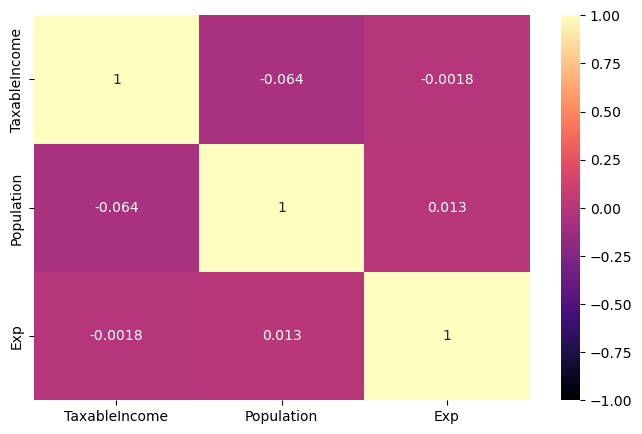

In [9]:
plt.figure(figsize=(8,5))
sns.heatmap(fraud1.corr(),vmax = 1,vmin=-1,annot=True,cmap='magma')
plt.show()

<Figure size 1200x1200 with 0 Axes>

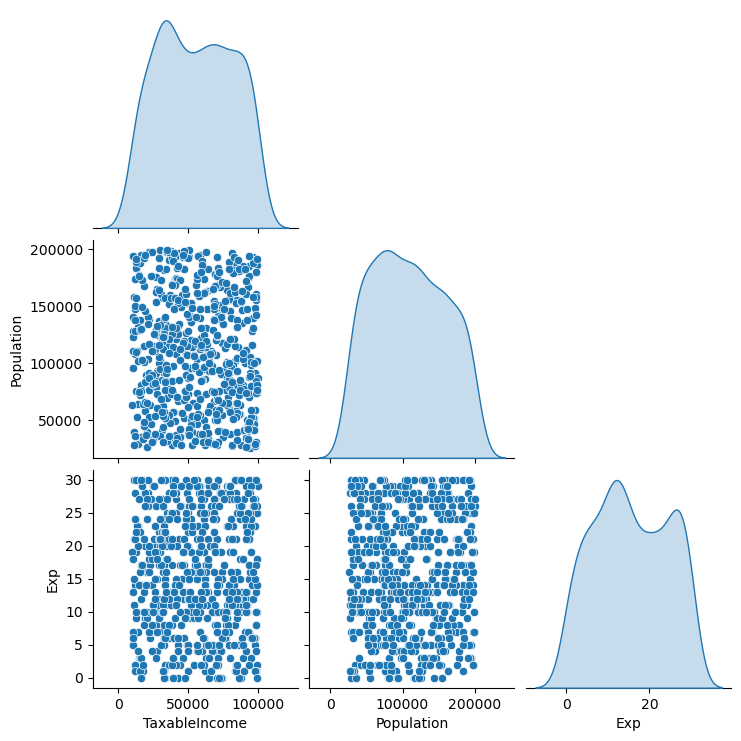

In [10]:
plt.figure(figsize=(12,12))
sns.pairplot(fraud1,diag_kind='kde',corner=True)
plt.show()

In [11]:
# Let's create new target variable TaxInc based on TaxableIncome and convert it into categorical:

fraud2 = fraud1.copy()

fraud2.insert(6,'TaxInc'," ")

for i in range(0,len(fraud2['TaxableIncome']),1):
    if fraud2['TaxableIncome'].iloc[i] <= 30000:
        fraud2['TaxInc'].iloc[i] = 'Risky'
    else:
        fraud2['TaxInc'].iloc[i] = 'Good'
        
        
fraud2.drop('TaxableIncome',axis=1,inplace=True) #Dropping TaxableIncome column
fraud2.head()

,Undergrad,MaritalStatus,Population,Exp,Urban,TaxInc
0,NO,Single,50047,10,YES,Good
1,YES,Divorced,134075,18,YES,Good
2,NO,Married,160205,30,YES,Good
3,YES,Single,193264,15,YES,Good
4,NO,Married,27533,28,NO,Good


In [13]:
fraud = fraud2.copy()

In [14]:
LE = LabelEncoder()
fraud['Undergrad']= LE.fit_transform(fraud['Undergrad'])
fraud['MaritalStatus']= LE.fit_transform(fraud['MaritalStatus'])
fraud['Urban']= LE.fit_transform(fraud['Urban'])
fraud['TaxInc']= LE.fit_transform(fraud['TaxInc'])

In [15]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Undergrad      600 non-null    int32
 1   MaritalStatus  600 non-null    int32
 2   Population     600 non-null    int64
 3   Exp            600 non-null    int64
 4   Urban          600 non-null    int32
 5   TaxInc         600 non-null    int32
dtypes: int32(4), int64(2)
memory usage: 18.9 KB


In [16]:
fraud['Undergrad']=fraud['Undergrad'].astype('category')
fraud['MaritalStatus']=fraud['MaritalStatus'].astype('category')
fraud['Urban']=fraud['Urban'].astype('category')
fraud['TaxInc']=fraud['TaxInc'].astype('category')
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Undergrad      600 non-null    category
 1   MaritalStatus  600 non-null    category
 2   Population     600 non-null    int64   
 3   Exp            600 non-null    int64   
 4   Urban          600 non-null    category
 5   TaxInc         600 non-null    category
dtypes: category(4), int64(2)
memory usage: 12.3 KB


In [18]:
fraud['TaxInc'].value_counts()

0    476
1    124
Name: TaxInc, dtype: int64

In [17]:
# Let's split df into features and target:
y = fraud['TaxInc']
x = fraud.drop('TaxInc',axis=1)

In [19]:
# Let's further split X & y into train and test:
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.3,random_state=42)

## Random Forest Model 

In [20]:
model1 = RandomForestClassifier(random_state=42)
model1.fit(x_train,y_train)
y_pred = model1.predict(x_train)
print('Train data score: ',accuracy_score(y_train,y_pred))
y_test_pred = model1.predict(x_test)
print('Test data score: ',accuracy_score(y_test,y_test_pred))

Train data score:  1.0
Test data score:  0.7555555555555555


In [21]:
# We know that target feature is imbalanced, hence let's stratify it and try the same model again:
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.25,random_state=42,stratify=y)

In [22]:
model1 = RandomForestClassifier(random_state=42)
model1.fit(x_train,y_train)
y_pred = model1.predict(x_train)
print('Train data score: ',accuracy_score(y_train,y_pred))
y_test_pred = model1.predict(x_test)
print('Test data score: ',accuracy_score(y_test,y_test_pred))

Train data score:  1.0
Test data score:  0.7666666666666667


In [48]:
# Let's try Grid Search and check for better accuracy score models:
RF = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [3,5,10],
          'n_estimators': [100,50,10,20],
          'min_samples_leaf':[3,2,4,5,6,8,9,10],
          'min_samples_split': [2,3,4,5,8,10,15,20,22,25]}
inner_cv = KFold(n_splits=2,shuffle=True,random_state=42)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=42)

grid_search = GridSearchCV(estimator= RF, param_grid=params, cv = inner_cv, n_jobs=-1,verbose=1, scoring="accuracy")
grid_search.fit(x, y)
rf_best = grid_search.best_estimator_
total_score = cross_val_score(grid_search,X=x,y=y,cv=outer_cv)
print('Total_Scores           :', np.round(total_score*100),2)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)


Fitting 2 folds for each of 960 candidates, totalling 1920 fits
Fitting 2 folds for each of 960 candidates, totalling 1920 fits
Fitting 2 folds for each of 960 candidates, totalling 1920 fits
Fitting 2 folds for each of 960 candidates, totalling 1920 fits
Fitting 2 folds for each of 960 candidates, totalling 1920 fits
Fitting 2 folds for each of 960 candidates, totalling 1920 fits
Total_Scores           : [78. 78. 79. 83. 78.] 2
Best Score             : 0.7933333333333333
RF Best Model          : RandomForestClassifier(max_depth=3, min_samples_leaf=3, n_jobs=-1,
                       random_state=42)


In [49]:
model2 = RandomForestClassifier(random_state=42,n_estimators = 100,max_depth=3,
                                min_samples_leaf=3)
model2.fit(x_train,y_train)
y_pred = model2.predict(x_train)
print('Train data score: ',accuracy_score(y_train,y_pred))
y_test_pred = model2.predict(x_test)
print('Test data score: ',accuracy_score(y_test,y_test_pred))

Train data score:  0.7933333333333333
Test data score:  0.7933333333333333


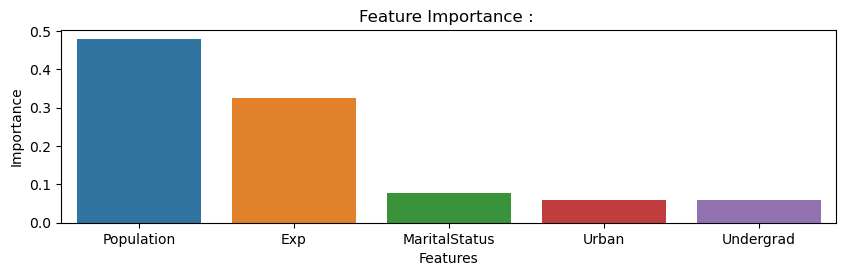

In [52]:
#Let's find out important features:
imp_df = pd.DataFrame({'Features': x.columns, 'Importance': model2.feature_importances_})
plt.figure(figsize=(10,2.5))
sns.barplot(y='Importance',x='Features',data = imp_df.sort_values(by='Importance',ascending=False))
plt.title('Feature Importance : ')
plt.show()

In [50]:
classification_report(y_test,y_test_pred,output_dict=True)

{'0': {'precision': 0.7933333333333333,
  'recall': 1.0,
  'f1-score': 0.8847583643122676,
  'support': 119},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 31},
 'accuracy': 0.7933333333333333,
 'macro avg': {'precision': 0.39666666666666667,
  'recall': 0.5,
  'f1-score': 0.4423791821561338,
  'support': 150},
 'weighted avg': {'precision': 0.6293777777777778,
  'recall': 0.7933333333333333,
  'f1-score': 0.7019083023543989,
  'support': 150}}

In [51]:
confusion_matrix(y_test,y_test_pred)

array([[119,   0],
       [ 31,   0]], dtype=int64)